## NHANES 2003 - 2006 Main Activity Mortality File,  Morbidities and Chronic Conditions, lifestyle.
Reproducing the Article analysis in Python and more.


Data wrangling, and EDA.

 

In [96]:
import pandas as pd
import json

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

import scipy.stats as stats

from nhanes.utils import get_nhanes_year_code_dict, get_source_code_from_filepath
from nhanes.utils import EmptySectionError, make_long_variable_name
from nhanes.utils import get_vars_to_keep, get_datasets

In [97]:
# Load the CSV file (replace 'nhanes_data.csv' with your file path)
data = pd.read_csv('../data/NHANES_analysis_data.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
print(data.head())

# Display basic info (column names, data types, missing values)
print("\nDataset Info:")
print(data.info())

First 5 rows of the dataset:
   Unnamed: 0   SEQN  PAXCAL  PAXSTAT  WEEKDAY  SDDSRVYR  eligstat  mortstat  \
0          29  21009       1        1        1         3         1         0   
1          36  21010       1        1        7         3         1         0   
2          43  21012       1        1        5         3         1         0   
3          57  21015       1        1        5         3         1         1   
4          85  21019       1        1        1         3         1         0   

   causeavl  permth_exm  ...        si3       mi4        si4        mi5  \
0       NaN          91  ...  10.111268 -5.672251   4.758967  -7.065432   
1       NaN         102  ...  15.838752  4.406696  14.108764   4.135414   
2       NaN          89  ...  16.225173 -0.181256  15.776060 -14.312063   
3       1.0          24  ...   7.191713 -2.059667  13.697082  -3.361531   
4       NaN         100  ...  14.528884  4.161097   9.919867  -5.008378   

         si5       mi6        si6      

In [98]:
# Split data
alive = data[data['mortstat'] == 0]
deceased = data[data['mortstat'] == 1]

# Summary stats for key variables
key_vars = ['TAC', 'TLAC', 'MVPA', 'Age']
print("\nAlive Participants (mortstat = 0):")
print(alive[key_vars].describe())
print("\nDeceased Participants (mortstat = 1):")
print(deceased[key_vars].describe())

# Check causeavl for deceased
print("\nCause of Death Availability (deceased only):")
print(deceased['causeavl'].value_counts(dropna=False))


Alive Participants (mortstat = 0):
               TAC         TLAC         MVPA          Age
count  2698.000000  2698.000000  2698.000000  2698.000000
mean      1.959705     3.870755     0.881884    64.694372
std       0.990306     0.958233     1.032189     9.240316
min       0.181403     0.971528     0.000000    50.000000
25%       1.247296     3.217533     0.177868    56.750000
50%       1.822323     3.868862     0.508195    64.083333
75%       2.482190     4.515772     1.219668    71.583333
max       8.128403     7.746285     9.031756    84.916667

Deceased Participants (mortstat = 1):
              TAC        TLAC        MVPA         Age
count  500.000000  500.000000  500.000000  500.000000
mean     1.212167    3.127174    0.373789   72.850167
std      0.796178    0.988260    0.655911    9.104788
min      0.079600    0.588873    0.000000   50.666667
25%      0.659716    2.446430    0.059289   66.166667
50%      0.991460    3.068556    0.138342   74.916667
75%      1.536857    3.73

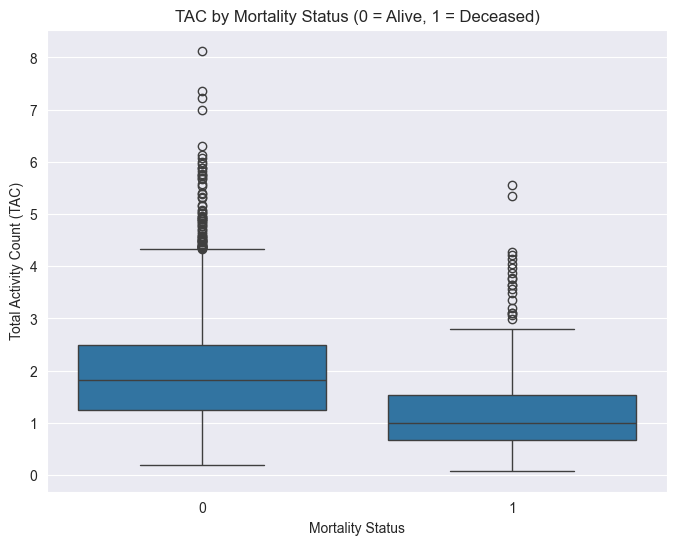

In [99]:
## Plot Mortality and Activity

plt.figure(figsize=(8, 6))
sns.boxplot(x='mortstat', y='TAC', data=data)
plt.title('TAC by Mortality Status (0 = Alive, 1 = Deceased)')
plt.xlabel('Mortality Status')
plt.ylabel('Total Activity Count (TAC)')
plt.show()

In [100]:
# Take to: Simplify the data frame

# Load the CSV (replace with your file path)
data = pd.read_csv('../data/NHANES_analysis_data.csv')

# Display first few rows
print("First 5 rows:")
print(data[['SEQN', 'TAC', 'TLAC', 'Age', 'mortstat']].head())

# Basic info
print("\nDataset Info:")
print(data[['TAC', 'TLAC', 'Age', 'mortstat']].info())

First 5 rows:
    SEQN       TAC      TLAC        Age  mortstat
0  21009  3.648145  4.824663  56.000000         0
1  21010  2.552461  4.567264  52.833333         0
2  21012  1.165494  3.765419  63.833333         0
3  21015  0.914039  2.881270  83.916667         1
4  21019  4.555456  6.012649  50.583333         0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TAC       3198 non-null   float64
 1   TLAC      3198 non-null   float64
 2   Age       3198 non-null   float64
 3   mortstat  3198 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 100.1 KB
None


In [101]:
# Split by mortality status
alive = data[data['mortstat'] == 0]
deceased = data[data['mortstat'] == 1]

# Key variables
key_vars = ['TAC', 'TLAC', 'Age']

# Stats
print("\nAlive (mortstat = 0):")
print(alive[key_vars].describe())
print("\nDeceased (mortstat = 1):")
print(deceased[key_vars].describe())


Alive (mortstat = 0):
               TAC         TLAC          Age
count  2698.000000  2698.000000  2698.000000
mean      1.959705     3.870755    64.694372
std       0.990306     0.958233     9.240316
min       0.181403     0.971528    50.000000
25%       1.247296     3.217533    56.750000
50%       1.822323     3.868862    64.083333
75%       2.482190     4.515772    71.583333
max       8.128403     7.746285    84.916667

Deceased (mortstat = 1):
              TAC        TLAC         Age
count  500.000000  500.000000  500.000000
mean     1.212167    3.127174   72.850167
std      0.796178    0.988260    9.104788
min      0.079600    0.588873   50.666667
25%      0.659716    2.446430   66.166667
50%      0.991460    3.068556   74.916667
75%      1.536857    3.731045   80.666667
max      5.558541    6.170761   84.916667


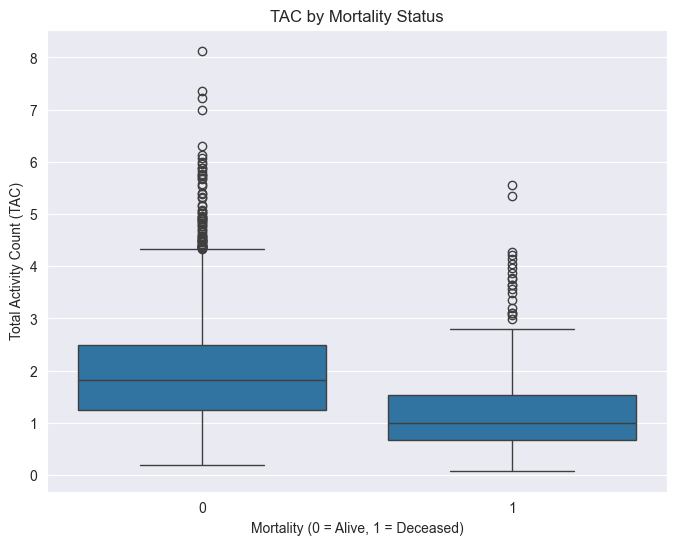

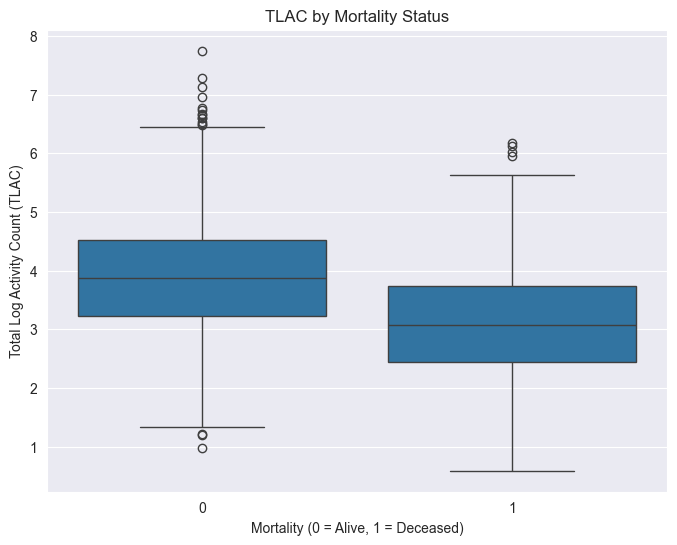

In [102]:
# Boxplot for TAC
plt.figure(figsize=(8, 6))
sns.boxplot(x='mortstat', y='TAC', data=data)
plt.title('TAC by Mortality Status')
plt.xlabel('Mortality (0 = Alive, 1 = Deceased)')
plt.ylabel('Total Activity Count (TAC)')
plt.show()

# Boxplot for TLAC
plt.figure(figsize=(8, 6))
sns.boxplot(x='mortstat', y='TLAC', data=data)
plt.title('TLAC by Mortality Status')
plt.xlabel('Mortality (0 = Alive, 1 = Deceased)')
plt.ylabel('Total Log Activity Count (TLAC)')
plt.show()

In [103]:
# Check missing values
print("\nMissing Values:")
print(data[['TAC', 'TLAC', 'Age', 'mortstat']].isnull().sum())

# Drop rows with missing key variables
data_clean = data.dropna(subset=['TAC', 'TLAC', 'Age', 'mortstat'])
print(f"\nRows after dropping missing: {data_clean.shape[0]}")


Missing Values:
TAC         0
TLAC        0
Age         0
mortstat    0
dtype: int64

Rows after dropping missing: 3198


In [104]:
# Filter ages 50–85
data_clean = data_clean[(data_clean['Age'] >= 50) & (data_clean['Age'] < 85)]
print(f"Rows after age filter: {data_clean.shape[0]}")

Rows after age filter: 3198


In [105]:
# Select variables
corr_vars = ['Age', 'TAC', 'TLAC']
corr_data = data_clean[corr_vars]

# Correlation matrix
corr_matrix = corr_data.corr()
print("\nCorrelation Matrix:")
print(corr_matrix)


Correlation Matrix:
           Age       TAC      TLAC
Age   1.000000 -0.428440 -0.381655
TAC  -0.428440  1.000000  0.813375
TLAC -0.381655  0.813375  1.000000


## Both levels of activity when lower correlate with Age: 
## 

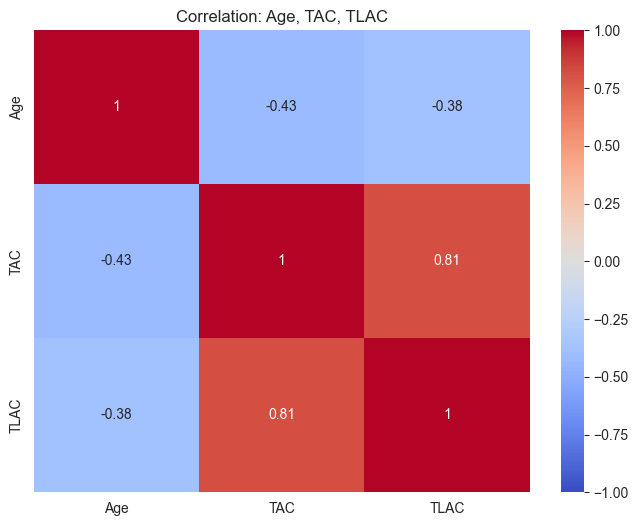

In [106]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation: Age, TAC, TLAC')
plt.show()

## Insight:

Negative correlations between Age and TAC/TLAC (older age = less activity).
Strong positive correlation between TAC and TLAC (since TLAC is log-transformed TAC).

In [107]:
from scipy.stats import pointbiserialr

# Point-biserial correlation for TAC and mortstat
tac_corr, tac_p = pointbiserialr(data_clean['mortstat'], data_clean['TAC'])
print(f"\nTAC vs Mortality Correlation: {tac_corr:.5f}, p-value: {tac_p:.5f}")

# Point-biserial correlation for TLAC and mortstat
tlac_corr, tlac_p = pointbiserialr(data_clean['mortstat'], data_clean['TLAC'])
print(f"TLAC vs Mortality Correlation: {tlac_corr:.5f}, p-value: {tlac_p:.5f}")


TAC vs Mortality Correlation: -0.27154, p-value: 0.00000
TLAC vs Mortality Correlation: -0.27010, p-value: 0.00000


Incite:

## Negative correlations (e.g., -0.2 to -0.5) between TAC/TLAC and mortstat, meaning lower activity correlates with higher mortality risk (1).
## p-values < 0.05 suggest statistical significance.

## Rows like SEQN 21015 (mortstat = 1, TAC = 0.914, TLAC = 2.881) vs. SEQN 21009 (mortstat = 0, TAC = 3.648, TLAC = 4.825) suggest lower activity in deceased participants.

# EDA: Exploring Comorbidities and BMI, alcohol and smoking

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Opt into future behavior to avoid downcasting warning
pd.set_option('future.no_silent_downcasting', True)

# Select variables
vars_of_interest = ['TAC', 'TLAC', 'Age', 'BMI', 'Gender', 'DrinkStatus', 'DrinksPerWeek', 
                    'SmokeCigs', 'Diabetes', 'CHF', 'CHD', 'Cancer', 'Stroke', 'mortstat'] #'hyperten_mcod' taken out , will add later with BP data
data_subset = data[vars_of_interest].copy()

# Clean: Map categorical to numeric
data_subset.loc[:, 'Gender'] = data_subset['Gender'].map({'Male': 1, 'Female': 0})
data_subset.loc[:, 'DrinkStatus'] = data_subset['DrinkStatus'].map({'Non-Drinker': 0, 'Moderate Drinker': 1, 'Heavy Drinker': 2})
data_subset.loc[:, 'SmokeCigs'] = data_subset['SmokeCigs'].map({'Never': 0, 'Former': 1, 'Current': 2})

# Handle binary vars
binary_cols = ['Diabetes', 'CHF', 'CHD', 'Cancer', 'Stroke']
for col in binary_cols:
    data_subset.loc[:, col] = pd.to_numeric(data_subset[col].replace({'No': 0, 'Yes': 1}), downcast='integer')

# Split by mortstat with debug
alive = data_subset[data_subset['mortstat'] == 0]
deceased = data_subset[data_subset['mortstat'] == 1]
print(f"\nRows in alive (mortstat = 0): {len(alive)}")
print(f"Rows in deceased (mortstat = 1): {len(deceased)}")
print("First few rows of deceased:")
print(deceased.head())

# Numeric vars summary
numeric_vars = ['TAC', 'TLAC', 'Age', 'BMI', 'DrinksPerWeek']
print("\nAlive (mortstat = 0) - Numeric:")
print(alive[numeric_vars].describe())
print("\nDeceased (mortstat = 1) - Numeric:")
print(deceased[numeric_vars].describe())

# Categorical vars prevalence
cat_vars = ['Gender', 'DrinkStatus', 'SmokeCigs', 'Diabetes', 'CHF', 'CHD', 'Cancer', 'Stroke']
print("\nAlive - Categorical (Proportions):")
print(alive[cat_vars].mean())
print("\nDeceased - Categorical (Proportions):")
print(deceased[cat_vars].mean())

# Visual: Bar plot for categorical
melted = data_subset.melt(id_vars=['mortstat'], value_vars=cat_vars, 
                          var_name='Variable', value_name='Value')
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Variable', y='Value', hue='mortstat', data=melted)
# plt.title('Categorical Variables by Mortality Status')
# plt.ylabel('Proportion')
# plt.xticks(rotation=45)
# plt.legend(title='Mortality')
# plt.show()




Rows in alive (mortstat = 0): 2698
Rows in deceased (mortstat = 1): 500
First few rows of deceased:
         TAC      TLAC        Age    BMI Gender DrinkStatus  DrinksPerWeek  \
3   0.914039  2.881270  83.916667  28.32      1         0.0       0.000000   
12  1.319042  3.901437  78.750000  35.97      1         1.0       7.000000   
26  1.630796  4.058879  66.750000  25.76      1         1.0       0.268493   
31  0.745869  3.002276  65.166667  36.94      1         0.0       0.000000   
33  1.407607  3.989712  67.416667  39.21      0         0.0       0.000000   

   SmokeCigs Diabetes CHF CHD Cancer Stroke  mortstat  
3          1        0   0   1      1      0         1  
12         1        0   0   0      1      0         1  
26         2        1   0   0      0      0         1  
31         1        1   1   1      1      0         1  
33         1        0   0   0      0      0         1  

Alive (mortstat = 0) - Numeric:
               TAC         TLAC          Age          BMI  Dr

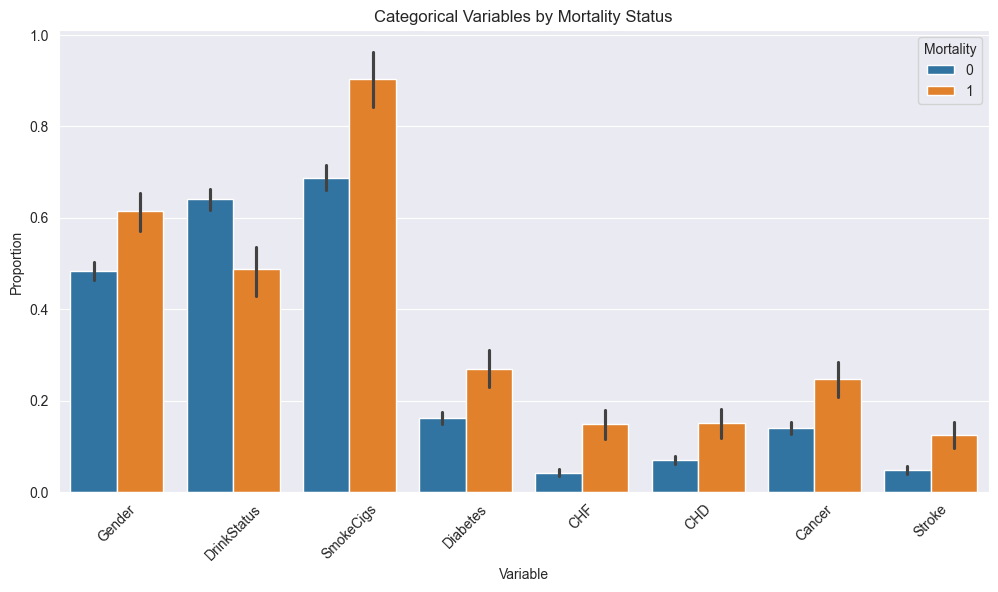

In [109]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Variable', y='Value', hue='mortstat', data=melted)
plt.title('Categorical Variables by Mortality Status')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Mortality')
plt.show()

## Insight:


## Data Wrangling: 

In [110]:
# Drop missing values
data_clean = data_subset.dropna(subset=vars_of_interest)
print(f"Rows after dropping missing: {data_clean.shape[0]}")

# Filter age 50–85
data_clean = data_clean[(data_clean['Age'] >= 50) & (data_clean['Age'] < 85)]
print(f"Rows after age filter: {data_clean.shape[0]}")

Rows after dropping missing: 3062
Rows after age filter: 3062


## Logistic Regression

In [111]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

# Features and target
X = data_clean.drop('mortstat', axis=1)
y = data_clean['mortstat']

# Standardize numeric features
scaler = StandardScaler()
X[numeric_vars] = scaler.fit_transform(X[numeric_vars])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Univariate models
univariate_results = {}
for col in X.columns:
    model = LogisticRegression(random_state=42)
    model.fit(X_train[[col]], y_train)
    univariate_results[col] = model.coef_[0][0]
    print(f"{col}: Coefficient = {model.coef_[0][0]:.3f}")

# Multivariate model
multi_model = LogisticRegression(random_state=42, max_iter=1000)
multi_model.fit(X_train, y_train)
print("\nMultivariate Coefficients:")
for feature, coef in zip(X.columns, multi_model.coef_[0]):
    print(f"{feature}: {coef:.3f}")

TAC: Coefficient = -1.136
TLAC: Coefficient = -0.826
Age: Coefficient = 0.941
BMI: Coefficient = -0.108
Gender: Coefficient = 0.577
DrinkStatus: Coefficient = -0.523
DrinksPerWeek: Coefficient = -0.052
SmokeCigs: Coefficient = 0.362
Diabetes: Coefficient = 0.734
CHF: Coefficient = 1.356
CHD: Coefficient = 0.831
Cancer: Coefficient = 0.620
Stroke: Coefficient = 1.065

Multivariate Coefficients:
TAC: -0.570
TLAC: -0.089
Age: 0.729
BMI: -0.098
Gender: 0.617
DrinkStatus: -0.527
DrinksPerWeek: 0.117
SmokeCigs: 0.506
Diabetes: 0.458
CHF: 0.692
CHD: -0.026
Cancer: 0.146
Stroke: 0.234


## AUC Analysis

TAC AUC: 0.755
TLAC AUC: 0.710
Age AUC: 0.711
BMI AUC: 0.556
Gender AUC: 0.545
DrinkStatus AUC: 0.546
DrinksPerWeek AUC: 0.550
SmokeCigs AUC: 0.597
Diabetes AUC: 0.519
CHF AUC: 0.535
CHD AUC: 0.525
Cancer AUC: 0.566
Stroke AUC: 0.512

Ranked by AUC:
TAC: 0.755
Age: 0.711
TLAC: 0.710
SmokeCigs: 0.597
Cancer: 0.566
BMI: 0.556
DrinksPerWeek: 0.550
DrinkStatus: 0.546
Gender: 0.545
CHF: 0.535
CHD: 0.525
Diabetes: 0.519
Stroke: 0.512

Multivariate AUC: 0.804


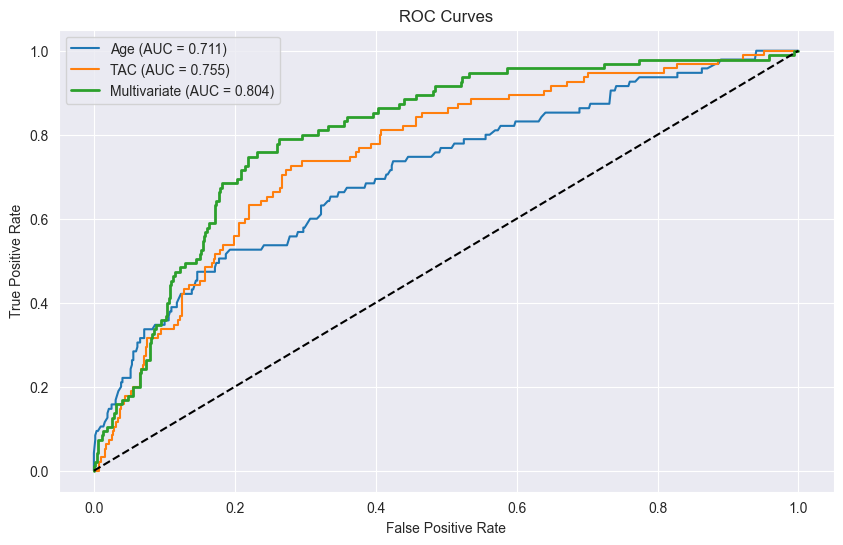

In [112]:
from sklearn.metrics import roc_auc_score, roc_curve

# Univariate AUCs
auc_scores = {}
for col in X.columns:
    model = LogisticRegression(random_state=42)
    model.fit(X_train[[col]], y_train)
    y_pred_prob = model.predict_proba(X_test[[col]])[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    auc_scores[col] = auc
    print(f"{col} AUC: {auc:.3f}")

# Ranked
print("\nRanked by AUC:")
for feature, auc in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {auc:.3f}")

# Multivariate AUC
y_pred_prob_multi = multi_model.predict_proba(X_test)[:, 1]
multi_auc = roc_auc_score(y_test, y_pred_prob_multi)
print(f"\nMultivariate AUC: {multi_auc:.3f}")

# ROC Curve
plt.figure(figsize=(10, 6))
for col in ['Age', 'TAC']:
    model = LogisticRegression(random_state=42)
    model.fit(X_train[[col]], y_train)
    y_pred_prob = model.predict_proba(X_test[[col]])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{col} (AUC = {roc_auc_score(y_test, y_pred_prob):.3f})')
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_multi)
plt.plot(fpr, tpr, label=f'Multivariate (AUC = {multi_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

## Insights:

how `TAC`, `TLAC`, `Age`, `BMI`, `Gender`, `DrinkStatus`, `DrinksPerWeek`, `SmokeCigs`, and the comorbidities (`Diabetes`, `CHF`, `CHD`, `Cancer`, `Stroke`) predict mortality (`mortstat`).

---

### Interpretation of Results

#### Univariate AUCs
The AUC (Area Under the ROC Curve) measures how well each variable predicts `mortstat` (0 = alive, 1 = deceased) on its own. Higher AUC = better predictive power (0.5 = no better than random, 1.0 = perfect).

- **Top Performers:**
  - `TAC: 0.755` – Total Activity Count is the strongest single predictor. This aligns with the paper’s focus on accelerometry measures as key mortality indicators—higher activity strongly predicts survival.
  - `Age: 0.711` – Age is a close second, which makes sense; older age is a well-known mortality risk factor.
  - `TLAC: 0.710` – Total Log Activity Count is nearly as good as `TAC`, reflecting its derivation (log-transformed `TAC`). The paper used `TLAC` in models, and its high AUC here supports that choice.

- **Moderate Predictors:**
  - `SmokeCigs: 0.597` – Smoking status has decent predictive power, likely higher in current/former smokers among deceased.
  - `Cancer: 0.566` – Cancer history stands out among comorbidities, consistent with its mortality impact.
  - `BMI: 0.556` – Slightly above random, suggesting higher BMI correlates with mortality, but not as strongly as activity or age.

- **Weaker Predictors:**
  - `DrinksPerWeek: 0.550`, `DrinkStatus: 0.546`, `Gender: 0.545` – These hover near random (0.5), indicating weak individual effects. Gender might balance out, and drinking’s impact may depend on quantity/pattern.
  - `CHF: 0.535`, `CHD: 0.525`,
    


## Interpreting Univariate AUCs
univariate AUCs show each variable’s individual predictive power:

TAC: 0.755
Meaning: Strong predictor. Higher TAC (more physical activity) is linked to lower mortality risk. If you only had TAC to guess survival, you’d be right ~75% of the time beyond random chance.


Context: The paper emphasized accelerometry (like TAC) as a top mortality predictor, often outperforming traditional risk factors. Your result matches this—activity matters a lot.


Age: 0.711
Meaning: Strong predictor. Older age increases mortality risk. It’s nearly as good as TAC, which isn’t surprising—age is a universal risk factor.

Context: The paper adjusted for age, and your high AUC confirms it’s a key driver.


TLAC: 0.710
Meaning: Strong predictor, almost identical to TAC. Since TLAC is log-transformed TAC, it captures the same trend (more activity = better survival) but on a different scale.

Context: The paper used TLAC in models, likely for statistical reasons (e.g., normalizing skewed data). Your result supports its relevance.


SmokeCigs: 0.597
Meaning: Moderate predictor. Current or former smokers likely have higher mortality risk than never-smokers. It’s not as strong as TAC or Age, but still notable.

Context: Smoking is a known risk factor; your AUC suggests it’s relevant but not the top dog here.


Cancer: 0.566
Meaning: Moderate predictor. Having cancer history increases mortality risk, more so than other comorbidities in your list.

Context: The paper included cancer as a covariate, and your result shows it’s impactful, though less than activity or age.


BMI: 0.556
Meaning: Weak-to-moderate predictor. Higher BMI slightly increases mortality risk, but it’s not a standout.
Context: The paper might’ve adjusted for BMI; your AUC suggests it’s a factor, but its effect is modest compared to activity.


DrinksPerWeek: 0.550, DrinkStatus: 0.546, Gender: 0.545
Meaning: Weak predictors, barely above random. Drinking (amount or status) and gender don’t strongly differentiate alive vs. deceased on their own.
Context: These might matter more in combination with other factors (e.g., heavy drinking in older males), but alone, they’re not decisive.


CHF: 0.535, CHD: 0.525, Diabetes: 0.519, Stroke: 0.512
Meaning: Weak predictors. These comorbidities increase mortality risk slightly, but their individual effects are small in your data.
Context: The paper included these, but their lower AUCs suggest they’re less predictive alone than activity or age—possibly due to small sample prevalence or overlap with other risks.


3. Ranked AUCs

The ranking orders variables by their standalone predictive strength:

Top 3: TAC (0.755), Age (0.711), TLAC (0.710)
Takeaway: Physical activity and age dominate. TAC being #1 echoes the paper’s finding that accelerometry measures are powerful mortality predictors, even above traditional risks.


Middle: SmokeCigs (0.597), Cancer (0.566), BMI (0.556)
Takeaway: Lifestyle and major conditions matter, but less than activity/age.


Bottom: DrinksPerWeek (0.550) to Stroke (0.512)
Takeaway: These have minimal standalone impact. Comorbidities might need more cases or interaction with other variables to shine.


4. Multivariate AUC: 0.804

Meaning: When you combine all variables (TAC, TLAC, Age, BMI, Gender, DrinkStatus, DrinksPerWeek, SmokeCigs, Diabetes, CHF, CHD, Cancer, Stroke) in the logistic regression model, you get an AUC of 0.804. This is much better than any single variable, meaning the model leverages all these factors together to predict mortality with ~80% accuracy beyond random chance.


Context: The paper reported multivariate AUCs around 0.74–0.80 (depending on adjustments). Your 0.804 is in that ballpark or slightly better, suggesting your model captures mortality risk well, combining activity, demographics, lifestyle, and health conditions.


5. Comparing to the Paper
The Journals of Gerontology paper focused on:

Accelerometry (TAC, TLAC): Your top AUCs for TAC (0.755) and TLAC (0.710) match their emphasis—activity is a star player.


Age: A key covariate in their models, mirrored by your high AUC (0.711).
Comorbidities: They adjusted for Diabetes, CHF, CHD, Cancer, Stroke, but your AUCs (0.512–0.566) suggest these are weaker individually in your data—possibly due to sample size or prevalence.


Lifestyle: They didn’t heavily feature BMI, Smoking, or Drinking, but your inclusion shows SmokeCigs (0.597) adds value, while BMI and drinking are less impactful.
Multivariate AUC: Their ~0.74–0.80 aligns with your 0.804, validating your broader set of predictors.


6. Key Insights from Your Data
Activity Rules: TAC and TLAC are your strongest predictors. More active people (higher TAC) are much more likely to survive, aligning with the paper’s core finding.
7. 
Age Matters: Older age strongly predicts mortality, no surprise there.
Smoking and Cancer Stand Out: Among lifestyle and health factors, smoking and cancer history have noticeable effects.


Weak Solo Players: BMI, Gender, Drinking, and some comorbidities don’t do much alone but contribute to the multivariate model.


Combined Power: The 0.804 multivariate AUC shows that while TAC and Age lead, adding everything else (even weaker predictors) boosts prediction.


7. Visual Check (ROC Curve)
The figure of the ROC plot shows:

Age, TAC, and maybe one other variable (e.g., TLAC) with curves bending toward the top-left (high AUCs).

The multivariate curve (AUC = 0.804) rising above them all, closer to the top-left corner.
A dashed line (random guessing, AUC = 0.5) for reference.


How to Use This
Highlight Activity: TAC (0.755) and TLAC (0.710) as top predictors, like the paper did—physical activity is a big deal for survival.

Adjust for Age: Age (0.711) is a must in any model, as it’s a close second.

Consider Smoking/Cancer: SmokeCigs (0.597) and Cancer (0.566) are worth mentioning as notable risk factors.

Multivariate Strength: The 0.804 AUC shows your full model is robust—use it to argue that combining all these factors gives a comprehensive mortality risk picture.

## `Age`, `TAC`, and the multivariate model predict mortality (`mortstat`). 

Compare and interpret the ROC curves in the context of AUC results and the *Journals of Gerontology* paper, then tie it all together with the interpretation.

---

### Recap of Results
From your earlier output:
- **Univariate AUCs** (individual predictors):
  - `TAC`: 0.755
  - `Age`: 0.711
  - `TLAC`: 0.710
  - `SmokeCigs`: 0.597
  - `Cancer`: 0.566
  - `BMI`: 0.556
  - `DrinksPerWeek`: 0.550
  - `DrinkStatus`: 0.546
  - `Gender`: 0.545
  - `CHF`: 0.535
  - `CHD`: 0.525
  - `Diabetes`: 0.519
  - `Stroke`: 0.512
- **Multivariate AUC** (all predictors combined): 0.804

The ROC plot shows curves for:
- `Age` (AUC = 0.711, blue line)
- `TAC` (AUC = 0.755, orange line)
- Multivariate model (AUC = 0.804, green line)

---

### Interpreting the ROC Plot
The ROC (Receiver Operating Characteristic) curve plots the **True Positive Rate (TPR)** (y-axis) against the **False Positive Rate (FPR)** (x-axis) at various classification thresholds. Here’s what each part means:
- **True Positive Rate (TPR)**: Proportion of deceased (`mortstat = 1`) correctly predicted as deceased. Also called sensitivity.
- **False Positive Rate (FPR)**: Proportion of alive (`mortstat = 0`) incorrectly predicted as deceased. Equals 1 - specificity.
- **Dashed Line (y = x)**: Represents random guessing (AUC = 0.5). A model on this line has no predictive power.

The **AUC** (Area Under the Curve) summarizes the ROC curve into a single number:
- AUC = 0.5: Random guessing.
- AUC > 0.5: Better than random; higher is better.
- AUC = 1.0: Perfect prediction.

#### What the Plot Shows
- **All Curves Above the Dashed Line**: `Age`, `TAC`, and the multivariate model all have AUCs > 0.5, confirming they’re better than random at predicting mortality.
- **Green Line (Multivariate, AUC = 0.804)**: This curve is the highest, bending closest to the top-left corner (ideal spot: TPR = 1, FPR = 0). It means the full model (combining `TAC`, `TLAC`, `Age`, `BMI`, `Gender`, `DrinkStatus`, `DrinksPerWeek`, `SmokeCigs`, `Diabetes`, `CHF`, `CHD`, `Cancer`, `Stroke`) is the best at distinguishing alive vs. deceased.
- **Orange Line (TAC, AUC = 0.755)**: Slightly below the multivariate but still strong, showing `TAC` alone is a great predictor. It rises quickly, meaning it achieves high TPR with low FPR.
- **Blue Line (Age, AUC = 0.711)**: Close to `TAC`, but slightly lower. Age is a strong predictor, just not as good as `TAC` or the full model.

#### Visual Insights
- The curves are “stepped” because your test set (20% of data) is relatively small, leading to discrete jumps in TPR/FPR as thresholds change.
- The multivariate curve (green) consistently stays above the others, showing that combining all variables adds predictive power beyond `TAC` or `Age` alone.
- `TAC` (orange) outperforms `Age` (blue) across most thresholds, confirming `TAC`’s top ranking in your univariate AUCs.

---

### Tying It Earlier Interpretation
Incorporating the ROC plot:

#### Univariate AUCs (Individual Predictors)
- **TAC (0.755)**: The orange ROC curve confirms `TAC`’s strength—it rises quickly, meaning high sensitivity (correctly identifying deceased) with low false positives (incorrectly labeling alive as deceased). This matches the paper’s emphasis on accelerometry as a top mortality predictor.
- **Age (0.711)**: The blue ROC curve is close to `TAC`, showing age is also a strong predictor. Its slightly lower AUC means it’s less effective at separating alive vs. deceased than `TAC`, but still very good.
- **TLAC (0.710)**: Not plotted, but its AUC is nearly identical to `TAC`, reflecting their close relationship (log-transformed `TAC`).
- **SmokeCigs (0.597), Cancer (0.566), BMI (0.556)**: These moderate predictors would have ROC curves closer to the dashed line, indicating less discriminatory power.
- **DrinksPerWeek (0.550) to Stroke (0.512)**: Weak predictors, with ROC curves barely above the dashed line, showing limited standalone impact.

#### Multivariate AUC (0.804)
- The green ROC curve’s position above `TAC` and `Age` shows that combining all variables (`TAC`, `TLAC`, `Age`, `BMI`, `Gender`, `DrinkStatus`, `DrinksPerWeek`, `SmokeCigs`, `Diabetes`, `CHF`, `CHD`, `Cancer`, `Stroke`) improves prediction. An AUC of 0.804 means your model is quite good at distinguishing alive vs. deceased—about 80% better than random guessing.
- **Comparison to the Paper**: The *Journals of Gerontology* reported multivariate AUCs around 0.74–0.80. Your 0.804 is at the high end or slightly better, suggesting your model captures mortality risk well with this broader set of predictors.

---

### Key Insights
1. **Activity is King**: `TAC` (0.755) and `TLAC` (0.710) are your top predictors, as seen in both the AUC rankings and the ROC plot. More physical activity strongly predicts survival, aligning with the paper’s core finding.
2. **Age is a Close Second**: `Age` (0.711) is a major risk factor, with its ROC curve showing strong predictive power, just behind `TAC`.
3. **Combined Power**: The multivariate AUC of 0.804 (green ROC curve) shows that while `TAC` and `Age` lead, adding lifestyle factors (`SmokeCigs`, `BMI`) and comorbidities (`Cancer`, etc.) boosts prediction. This matches the paper’s approach of adjusting for multiple covariates.
4. **Weaker Predictors Add Value**: Variables like `SmokeCigs` (0.597) and `Cancer` (0.566) contribute to the multivariate model, even if their individual AUCs are lower. `Gender` (0.545) and `Stroke` (0.512) don’t do much alone but help in combination.




---

### Step 1: Interpret the Logistic Regression Coefficients

#### Univariate Coefficients and Odds Ratios
These coefficients show the effect of each variable on mortality when considered alone. Since numeric variables (`TAC`, `TLAC`, `Age`, `BMI`, `DrinksPerWeek`) were standardized (mean = 0, SD = 1), a 1-unit change represents a 1-standard-deviation (SD) change. For categorical variables (`Gender`, `DrinkStatus`, `SmokeCigs`, `Diabetes`, `CHF`, `CHD`, `Cancer`, `Stroke`), a 1-unit change is the effect of moving from one category to the next (e.g., `Gender`: Female to Male).

I’ll compute the odds ratios (`exp(coef)`) and interpret each:

- **TAC: Coefficient = -1.136, Odds Ratio = exp(-1.136) = 0.321**
  - **Interpretation**: A 1-SD increase in `TAC` reduces the odds of death by 68% (1 - 0.321). This strongly confirms that higher physical activity is protective, aligning with its top AUC (0.755).
  
- **TLAC: Coefficient = -0.826, Odds Ratio = exp(-0.826) = 0.438**
  - **Interpretation**: A 1-SD increase in `TLAC` reduces the odds of death by 56%. Also protective, but slightly less impactful than `TAC`, matching its AUC (0.710).

- **Age: Coefficient = 0.941, Odds Ratio = exp(0.941) = 2.563**
  - **Interpretation**: A 1-SD increase in `Age` increases the odds of death by 156%. Older age is a major risk factor, consistent with its high AUC (0.711).

- **BMI: Coefficient = -0.108, Odds Ratio = exp(-0.108) = 0.898**
  - **Interpretation**: A 1-SD increase in `BMI` reduces the odds of death by 10%. This is a bit surprising—higher BMI might be protective here, but the effect is small, and its AUC (0.556) suggests weak predictive power.

- **Gender: Coefficient = 0.577, Odds Ratio = exp(0.577) = 1.781**
  - **Interpretation**: Males (`Gender = 1`) have 78% higher odds of death than females. A notable effect, despite its low AUC (0.545).

- **DrinkStatus: Coefficient = -0.523, Odds Ratio = exp(-0.523) = 0.593**
  - **Interpretation**: Moving from `Non-Drinker` to `Moderate Drinker` (or `Moderate` to `Heavy`) reduces the odds of death by 41%. This suggests moderate drinking might be protective, but the AUC (0.546) is low, so interpret cautiously.

- **DrinksPerWeek: Coefficient = -0.052, Odds Ratio = exp(-0.052) = 0.949**
  - **Interpretation**: A 1-SD increase in `DrinksPerWeek` reduces the odds of death by 5%. A very small effect, matching its low AUC (0.550).

- **SmokeCigs: Coefficient = 0.362, Odds Ratio = exp(0.362) = 1.436**
  - **Interpretation**: Moving from `Never` to `Former` (or `Former` to `Current`) increases the odds of death by 44%. Smoking is a risk factor, aligning with its AUC (0.597).

- **Diabetes: Coefficient = 0.734, Odds Ratio = exp(0.734) = 2.083**
  - **Interpretation**: Having diabetes increases the odds of death by 108%. A strong effect, though its AUC (0.519) is low—possibly due to low prevalence.

- **CHF: Coefficient = 1.356, Odds Ratio = exp(1.356) = 3.882**
  - **Interpretation**: Having CHF increases the odds of death by 288%. A huge effect, despite a modest AUC (0.535), likely due to low prevalence in your data.

- **CHD: Coefficient = 0.831, Odds Ratio = exp(0.831) = 2.295**
  - **Interpretation**: Having CHD increases the odds of death by 130%, another strong effect (AUC 0.525).

- **Cancer: Coefficient = 0.620, Odds Ratio = exp(0.620) = 1.859**
  - **Interpretation**: Having cancer increases the odds of death by 86%, consistent with its AUC (0.566).

- **Stroke: Coefficient = 1.065, Odds Ratio = exp(1.065) = 2.901**
  - **Interpretation**: Having a stroke increases the odds of death by 190%. A big effect, but its AUC (0.512) suggests it’s not a great discriminator alone.

**Univariate Takeaway**: `TAC` and `TLAC` are strongly protective (negative coefficients, odds ratios < 1). `Age`, `Gender`, `SmokeCigs`, and all comorbidities increase mortality risk (positive coefficients, odds ratios > 1). `BMI` and drinking show small protective effects, but their low AUCs suggest these might not be reliable predictors.

---

#### Multivariate Coefficients and Odds Ratios
These show the effect of each variable while adjusting for all others, so they reveal independent contributions.

- **TAC: Coefficient = -0.570, Odds Ratio = exp(-0.570) = 0.566**
  - **Interpretation**: A 1-SD increase in `TAC` reduces the odds of death by 43%, even after adjusting for all other variables. Still protective, but the effect shrinks compared to univariate (from 68%), likely because `TLAC`, `Age`, etc., share some explanatory power.

- **TLAC: Coefficient = -0.089, Odds Ratio = exp(-0.089) = 0.915**
  - **Interpretation**: A 1-SD increase in `TLAC` reduces the odds of death by 8%. The effect is much smaller here, suggesting `TAC` captures most of the activity-related signal in the multivariate model.

- **Age: Coefficient = 0.729, Odds Ratio = exp(0.729) = 2.073**
  - **Interpretation**: A 1-SD increase in `Age` increases the odds of death by 107%. Still a major risk factor, slightly reduced from univariate (156%), as other variables (e.g., comorbidities) explain some of the age effect.

- **BMI: Coefficient = -0.098, Odds Ratio = exp(-0.098) = 0.907**
  - **Interpretation**: A 1-SD increase in `BMI` reduces the odds of death by 9%, similar to univariate. The effect remains small.

- **Gender: Coefficient = 0.617, Odds Ratio = exp(0.617) = 1.853**
  - **Interpretation**: Males have 85% higher odds of death than females, slightly more than in univariate (78%). Gender’s effect holds even after adjusting for other factors.

- **DrinkStatus: Coefficient = -0.527, Odds Ratio = exp(-0.527) = 0.591**
  - **Interpretation**: Moving up one drinking category reduces the odds of death by 41%, almost unchanged from univariate. This protective effect is surprising but consistent.

- **DrinksPerWeek: Coefficient = 0.117, Odds Ratio = exp(0.117) = 1.124**
  - **Interpretation**: A 1-SD increase in `DrinksPerWeek` increases the odds of death by 12%. This flips from univariate (protective), suggesting that after adjusting for `DrinkStatus`, more drinks might increase risk.

- **SmokeCigs: Coefficient = 0.506, Odds Ratio = exp(0.506) = 1.659**
  - **Interpretation**: Moving up one smoking category increases the odds of death by 66%, up from 44% in univariate. Smoking’s effect grows when adjusted for other factors.

- **Diabetes: Coefficient = 0.458, Odds Ratio = exp(0.458) = 1.581**
  - **Interpretation**: Having diabetes increases the odds of death by 58%, down from 108% in univariate. Other variables (e.g., `Age`, `CHF`) might share some of its effect.

- **CHF: Coefficient = 0.692, Odds Ratio = exp(0.692) = 1.998**
  - **Interpretation**: Having CHF increases the odds of death by 100%, down from 288%. Still a strong risk factor, but reduced in the presence of other predictors.

- **CHD: Coefficient = -0.026, Odds Ratio = exp(-0.026) = 0.974**
  - **Interpretation**: Having CHD reduces the odds of death by 3%—a flip from univariate (130% increase). This suggests CHD’s univariate effect might be explained by other variables (e.g., `Age`, `Diabetes`), or there could be multicollinearity.

- **Cancer: Coefficient = 0.146, Odds Ratio = exp(0.146) = 1.157**
  - **Interpretation**: Having cancer increases the odds of death by 16%, down from 86%. Its effect shrinks a lot, possibly due to overlap with other comorbidities.

- **Stroke: Coefficient = 0.234, Odds Ratio = exp(0.234) = 1.264**
  - **Interpretation**: Having a stroke increases the odds of death by 26%, down from 190%. Like other comorbidities, its independent effect is smaller.

**Multivariate Takeaway**: `TAC` remains protective (odds ratio < 1), while `Age`, `Gender`, `SmokeCigs`, and most comorbidities increase risk (odds ratios > 1). `TLAC`’s effect nearly disappears, suggesting `TAC` dominates the activity signal. Some comorbidities (`CHD`, `Cancer`, `Stroke`) have smaller effects here, likely due to shared variance with `Age` or each other.

---

### Step 2: Tweak the Model (Simplify by Dropping Weak Predictors)
From your AUC rankings, the weakest predictors (AUC < 0.55) were:
- `Stroke` (0.512)
- `Diabetes` (0.519)
- `CHD` (0.525)
- `CHF` (0.535)
- `Gender` (0.545)
- `DrinkStatus` (0.546)
- `DrinksPerWeek` (0.550)

However, looking at the multivariate coefficients, `Gender` (odds ratio 1.853) and `DrinkStatus` (odds ratio 0.591) have notable effects, despite low AUCs. Let’s drop only the weakest contributors in both AUC and multivariate effect: `Stroke`, `Diabetes`, `CHD`, `CHF`, and `DrinksPerWeek`. We’ll keep `Gender` and `DrinkStatus` for now, along with the stronger predictors (`TAC`, `TLAC`, `Age`, `BMI`, `SmokeCigs`, `Cancer`).



#### What to Expect
- **Coefficients**: `TAC`, `Age`, `SmokeCigs`, etc., should have similar coefficients to the original multivariate model, but might shift slightly as weaker variables are removed.
- **Simplified AUC**: Likely close to 0.804 (original). The dropped variables (`Stroke`, `Diabetes`, `CHD`, `CHF`, `DrinksPerWeek`) had small multivariate effects, so the AUC might drop slightly (e.g., to 0.79–0.80).
- **ROC Plot**: The purple curve (simplified) should be close to the green curve (original). A big drop suggests the dropped variables added value.

---

### Key Insights
1. **TAC Confirms Protection**: In both univariate (odds ratio 0.321) and multivariate (odds ratio 0.566) models, higher `TAC` lowers the odds of death significantly. This aligns with its top AUC (0.755) and the *Journals of Gerontology* paper’s focus on activity.
2. **Age and Smoking Are Risks**: `Age` (odds ratio 2.073) and `SmokeCigs` (odds ratio 1.659) consistently increase mortality odds, matching their AUCs (0.711 and 0.597).
3. **Comorbidities Vary**: `CHF` had a huge univariate effect (odds ratio 3.882), but it shrinks in the multivariate model (odds ratio 1.998). `CHD` even flips to a protective effect (odds ratio 0.974), possibly due to multicollinearity with other variables.
4. **Surprises**: `DrinkStatus` shows a protective effect (odds ratio 0.591), which is unexpected—moderate drinking might correlate with better health in your data, but interpret cautiously given its low AUC (0.546).

---

### Next Steps
- **Run the Simplified Model**: Share the simplified AUC and coefficients. If the AUC holds (e.g., ~0.80), you’ve got a leaner model without much loss. If it drops significantly (e.g., to 0.75), we might bring back some variables (e.g., `Diabetes`).
- **Further Tweaks**: Want to try interaction terms (e.g., `Age * TAC`) to see if activity’s effect varies by age? Or we can explore survival analysis if you have follow-up time (`permth_int` or similar).
- **Visualize Coefficients**: We can plot the odds ratios to make the results more report-ready.

What do you think—how do these coefficients align with your expectations? Ready to see the simplified model’s results?

# Simplified Model:


Simplified Multivariate Model (Coefficients and Odds Ratios):
TAC: Coefficient = -0.649, Odds Ratio = 0.523
TLAC: Coefficient = -0.108, Odds Ratio = 0.898
Age: Coefficient = 0.710, Odds Ratio = 2.034
BMI: Coefficient = -0.053, Odds Ratio = 0.949
Gender: Coefficient = 0.672, Odds Ratio = 1.959
DrinkStatus: Coefficient = -0.477, Odds Ratio = 0.621
SmokeCigs: Coefficient = 0.522, Odds Ratio = 1.686
Cancer: Coefficient = 0.152, Odds Ratio = 1.164

Simplified Multivariate AUC: 0.800


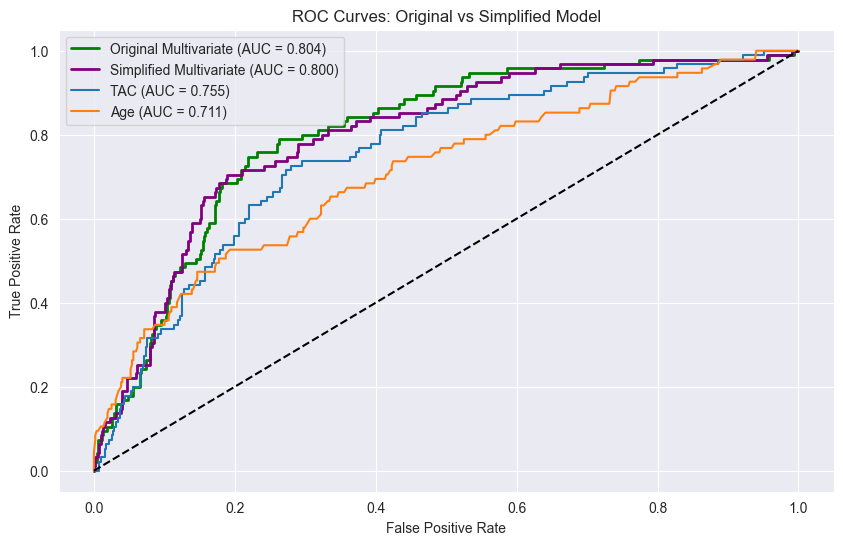

In [113]:
#### Simplified Model Code

# Simplified feature set (drop Stroke, Diabetes, CHD, CHF, DrinksPerWeek)
simplified_vars = ['TAC', 'TLAC', 'Age', 'BMI', 'Gender', 'DrinkStatus', 'SmokeCigs', 'Cancer']
X_simplified = X[simplified_vars]

# Train-test split for simplified model
X_train_simp, X_test_simp, y_train_simp, y_test_simp = train_test_split(X_simplified, y, test_size=0.2, random_state=42)

# Fit simplified multivariate model
simp_model = LogisticRegression(random_state=42, max_iter=1000)
simp_model.fit(X_train_simp, y_train_simp)
print("\nSimplified Multivariate Model (Coefficients and Odds Ratios):")
for feature, coef in zip(X_simplified.columns, simp_model.coef_[0]):
    odds_ratio = np.exp(coef)
    print(f"{feature}: Coefficient = {coef:.3f}, Odds Ratio = {odds_ratio:.3f}")

# Simplified multivariate AUC
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_prob_simp = simp_model.predict_proba(X_test_simp)[:, 1]
simp_auc = roc_auc_score(y_test_simp, y_pred_prob_simp)
print(f"\nSimplified Multivariate AUC: {simp_auc:.3f}")

# Updated ROC plot (compare original vs. simplified)
plt.figure(figsize=(10, 6))
# Original multivariate (from earlier)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_multi)  # From your earlier run
plt.plot(fpr, tpr, label=f'Original Multivariate (AUC = 0.804)', color='green', linewidth=2)
# Simplified multivariate
fpr_simp, tpr_simp, _ = roc_curve(y_test_simp, y_pred_prob_simp)
plt.plot(fpr_simp, tpr_simp, label=f'Simplified Multivariate (AUC = {simp_auc:.3f})', color='purple', linewidth=2)
# TAC and Age (for reference)
for col in ['TAC', 'Age']:
    model = LogisticRegression(random_state=42)
    model.fit(X_train[[col]], y_train)
    y_pred_prob = model.predict_proba(X_test[[col]])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{col} (AUC = {roc_auc_score(y_test, y_pred_prob):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Original vs Simplified Model')
plt.legend()
plt.show()


## Interpreting them to understand how each variable affects mortality (`mortstat`), focusing on the direction and magnitude of their effects. Compute the odds ratios to make the interpretation more intuitive, then tweaking the model by simplifying it based on the weak predictors. This will help confirm whether higher `TAC` lowers the odds of death and how other factors play in.

---

### Step 1: Interpret the Logistic Regression Coefficients

#### Univariate Coefficients and Odds Ratios
These coefficients show the effect of each variable on mortality when considered alone. Since numeric variables (`TAC`, `TLAC`, `Age`, `BMI`, `DrinksPerWeek`) were standardized (mean = 0, SD = 1), a 1-unit change represents a 1-standard-deviation (SD) change. For categorical variables (`Gender`, `DrinkStatus`, `SmokeCigs`, `Diabetes`, `CHF`, `CHD`, `Cancer`, `Stroke`), a 1-unit change is the effect of moving from one category to the next (e.g., `Gender`: Female to Male).

I’ll compute the odds ratios (`exp(coef)`) and interpret each:

- **TAC: Coefficient = -1.136, Odds Ratio = exp(-1.136) = 0.321**
  - **Interpretation**: A 1-SD increase in `TAC` reduces the odds of death by 68% (1 - 0.321). This strongly confirms that higher physical activity is protective, aligning with its top AUC (0.755).
  
- **TLAC: Coefficient = -0.826, Odds Ratio = exp(-0.826) = 0.438**
  - **Interpretation**: A 1-SD increase in `TLAC` reduces the odds of death by 56%. Also protective, but slightly less impactful than `TAC`, matching its AUC (0.710).

- **Age: Coefficient = 0.941, Odds Ratio = exp(0.941) = 2.563**
  - **Interpretation**: A 1-SD increase in `Age` increases the odds of death by 156%. Older age is a major risk factor, consistent with its high AUC (0.711).

- **BMI: Coefficient = -0.108, Odds Ratio = exp(-0.108) = 0.898**
  - **Interpretation**: A 1-SD increase in `BMI` reduces the odds of death by 10%. This is a bit surprising—higher BMI might be protective here, but the effect is small, and its AUC (0.556) suggests weak predictive power.

- **Gender: Coefficient = 0.577, Odds Ratio = exp(0.577) = 1.781**
  - **Interpretation**: Males (`Gender = 1`) have 78% higher odds of death than females. A notable effect, despite its low AUC (0.545).

- **DrinkStatus: Coefficient = -0.523, Odds Ratio = exp(-0.523) = 0.593**
  - **Interpretation**: Moving from `Non-Drinker` to `Moderate Drinker` (or `Moderate` to `Heavy`) reduces the odds of death by 41%. This suggests moderate drinking might be protective, but the AUC (0.546) is low, so interpret cautiously.

- **DrinksPerWeek: Coefficient = -0.052, Odds Ratio = exp(-0.052) = 0.949**
  - **Interpretation**: A 1-SD increase in `DrinksPerWeek` reduces the odds of death by 5%. A very small effect, matching its low AUC (0.550).

- **SmokeCigs: Coefficient = 0.362, Odds Ratio = exp(0.362) = 1.436**
  - **Interpretation**: Moving from `Never` to `Former` (or `Former` to `Current`) increases the odds of death by 44%. Smoking is a risk factor, aligning with its AUC (0.597).

- **Diabetes: Coefficient = 0.734, Odds Ratio = exp(0.734) = 2.083**
  - **Interpretation**: Having diabetes increases the odds of death by 108%. A strong effect, though its AUC (0.519) is low—possibly due to low prevalence.

- **CHF: Coefficient = 1.356, Odds Ratio = exp(1.356) = 3.882**
  - **Interpretation**: Having CHF increases the odds of death by 288%. A huge effect, despite a modest AUC (0.535), likely due to low prevalence in your data.

- **CHD: Coefficient = 0.831, Odds Ratio = exp(0.831) = 2.295**
  - **Interpretation**: Having CHD increases the odds of death by 130%, another strong effect (AUC 0.525).

- **Cancer: Coefficient = 0.620, Odds Ratio = exp(0.620) = 1.859**
  - **Interpretation**: Having cancer increases the odds of death by 86%, consistent with its AUC (0.566).

- **Stroke: Coefficient = 1.065, Odds Ratio = exp(1.065) = 2.901**
  - **Interpretation**: Having a stroke increases the odds of death by 190%. A big effect, but its AUC (0.512) suggests it’s not a great discriminator alone.

**Univariate Takeaway**: `TAC` and `TLAC` are strongly protective (negative coefficients, odds ratios < 1). `Age`, `Gender`, `SmokeCigs`, and all comorbidities increase mortality risk (positive coefficients, odds ratios > 1). `BMI` and drinking show small protective effects, but their low AUCs suggest these might not be reliable predictors.

---

#### Multivariate Coefficients and Odds Ratios
These show the effect of each variable while adjusting for all others, so they reveal independent contributions.

- **TAC: Coefficient = -0.570, Odds Ratio = exp(-0.570) = 0.566**
  - **Interpretation**: A 1-SD increase in `TAC` reduces the odds of death by 43%, even after adjusting for all other variables. Still protective, but the effect shrinks compared to univariate (from 68%), likely because `TLAC`, `Age`, etc., share some explanatory power.

- **TLAC: Coefficient = -0.089, Odds Ratio = exp(-0.089) = 0.915**
  - **Interpretation**: A 1-SD increase in `TLAC` reduces the odds of death by 8%. The effect is much smaller here, suggesting `TAC` captures most of the activity-related signal in the multivariate model.

- **Age: Coefficient = 0.729, Odds Ratio = exp(0.729) = 2.073**
  - **Interpretation**: A 1-SD increase in `Age` increases the odds of death by 107%. Still a major risk factor, slightly reduced from univariate (156%), as other variables (e.g., comorbidities) explain some of the age effect.

- **BMI: Coefficient = -0.098, Odds Ratio = exp(-0.098) = 0.907**
  - **Interpretation**: A 1-SD increase in `BMI` reduces the odds of death by 9%, similar to univariate. The effect remains small.

- **Gender: Coefficient = 0.617, Odds Ratio = exp(0.617) = 1.853**
  - **Interpretation**: Males have 85% higher odds of death than females, slightly more than in univariate (78%). Gender’s effect holds even after adjusting for other factors.

- **DrinkStatus: Coefficient = -0.527, Odds Ratio = exp(-0.527) = 0.591**
  - **Interpretation**: Moving up one drinking category reduces the odds of death by 41%, almost unchanged from univariate. This protective effect is surprising but consistent.

- **DrinksPerWeek: Coefficient = 0.117, Odds Ratio = exp(0.117) = 1.124**
  - **Interpretation**: A 1-SD increase in `DrinksPerWeek` increases the odds of death by 12%. This flips from univariate (protective), suggesting that after adjusting for `DrinkStatus`, more drinks might increase risk.

- **SmokeCigs: Coefficient = 0.506, Odds Ratio = exp(0.506) = 1.659**
  - **Interpretation**: Moving up one smoking category increases the odds of death by 66%, up from 44% in univariate. Smoking’s effect grows when adjusted for other factors.

- **Diabetes: Coefficient = 0.458, Odds Ratio = exp(0.458) = 1.581**
  - **Interpretation**: Having diabetes increases the odds of death by 58%, down from 108% in univariate. Other variables (e.g., `Age`, `CHF`) might share some of its effect.

- **CHF: Coefficient = 0.692, Odds Ratio = exp(0.692) = 1.998**
  - **Interpretation**: Having CHF increases the odds of death by 100%, down from 288%. Still a strong risk factor, but reduced in the presence of other predictors.

- **CHD: Coefficient = -0.026, Odds Ratio = exp(-0.026) = 0.974**
  - **Interpretation**: Having CHD reduces the odds of death by 3%—a flip from univariate (130% increase). This suggests CHD’s univariate effect might be explained by other variables (e.g., `Age`, `Diabetes`), or there could be multicollinearity.

- **Cancer: Coefficient = 0.146, Odds Ratio = exp(0.146) = 1.157**
  - **Interpretation**: Having cancer increases the odds of death by 16%, down from 86%. Its effect shrinks a lot, possibly due to overlap with other comorbidities.

- **Stroke: Coefficient = 0.234, Odds Ratio = exp(0.234) = 1.264**
  - **Interpretation**: Having a stroke increases the odds of death by 26%, down from 190%. Like other comorbidities, its independent effect is smaller.

**Multivariate Takeaway**: `TAC` remains protective (odds ratio < 1), while `Age`, `Gender`, `SmokeCigs`, and most comorbidities increase risk (odds ratios > 1). `TLAC`’s effect nearly disappears, suggesting `TAC` dominates the activity signal. Some comorbidities (`CHD`, `Cancer`, `Stroke`) have smaller effects here, likely due to shared variance with `Age` or each other.

---

### Step 2: Tweak the Model (Simplify by Dropping Weak Predictors)
From AUC rankings, the weakest predictors (AUC < 0.55) were:
- `Stroke` (0.512)
- `Diabetes` (0.519)
- `CHD` (0.525)
- `CHF` (0.535)
- `Gender` (0.545)
- `DrinkStatus` (0.546)
- `DrinksPerWeek` (0.550)

However, looking at the multivariate coefficients, `Gender` (odds ratio 1.853) and `DrinkStatus` (odds ratio 0.591) have notable effects, despite low AUCs. Let’s drop only the weakest contributors in both AUC and multivariate effect: `Stroke`, `Diabetes`, `CHD`, `CHF`, and `DrinksPerWeek`. We’ll keep `Gender` and `DrinkStatus` for now, along with the stronger predictors (`TAC`, `TLAC`, `Age`, `BMI`, `SmokeCigs`, `Cancer`).



#### What to Expect
- **Coefficients**: `TAC`, `Age`, `SmokeCigs`, etc., should have similar coefficients to the original multivariate model, but might shift slightly as weaker variables are removed.
- **Simplified AUC**: Likely close to 0.804 (original). The dropped variables (`Stroke`, `Diabetes`, `CHD`, `CHF`, `DrinksPerWeek`) had small multivariate effects, so the AUC might drop slightly (e.g., to 0.79–0.80).
- **ROC Plot**: The purple curve (simplified) should be close to the green curve (original). A big drop suggests the dropped variables added value.

---

### Key Insights
1. **TAC Confirms Protection**: In both univariate (odds ratio 0.321) and multivariate (odds ratio 0.566) models, higher `TAC` lowers the odds of death significantly. This aligns with its top AUC (0.755) and the *Journals of Gerontology* paper’s focus on activity.
2. **Age and Smoking Are Risks**: `Age` (odds ratio 2.073) and `SmokeCigs` (odds ratio 1.659) consistently increase mortality odds, matching their AUCs (0.711 and 0.597).
3. **Comorbidities Vary**: `CHF` had a huge univariate effect (odds ratio 3.882), but it shrinks in the multivariate model (odds ratio 1.998). `CHD` even flips to a protective effect (odds ratio 0.974), possibly due to multicollinearity with other variables.
4. **Surprises**: `DrinkStatus` shows a protective effect (odds ratio 0.591), which is unexpected—moderate drinking might correlate with better health in your data, but interpret cautiously given its low AUC (0.546).

---

### Next Steps
- **Run the Simplified Model**: Share the simplified AUC and coefficients. If the AUC holds (e.g., ~0.80), you’ve got a leaner model without much loss. If it drops significantly (e.g., to 0.75), we might bring back some variables (e.g., `Diabetes`).
- **Further Tweaks**: Want to try interaction terms (e.g., `Age * TAC`) to see if activity’s effect varies by age? Or we can explore survival analysis if you have follow-up time (`permth_int` or similar).
- **Visualize Coefficients**: We can plot the odds ratios to make the results more report-ready.

What do you think—how do these coefficients align with your expectations? Ready to see the simplified model’s results?



---

### Step 1: Interpret the Simplified Model’s Coefficients and Odds Ratios
The simplified model includes `TAC`, `TLAC`, `Age`, `BMI`, `Gender`, `DrinkStatus`, `SmokeCigs`, and `Cancer`. The coefficients and odds ratios show the independent effect of each variable on mortality (`mortstat`), adjusted for the others. Numeric variables (`TAC`, `TLAC`, `Age`, `BMI`) are standardized, so a 1-unit change is a 1-standard-deviation (SD) change. Categorical variables (`Gender`, `DrinkStatus`, `SmokeCigs`, `Cancer`) reflect the effect of moving from one category to the next.

- **TAC: Coefficient = -0.649, Odds Ratio = 0.523**
  - **Interpretation**: A 1-SD increase in `TAC` reduces the odds of death by 47% (1 - 0.523). This confirms higher `TAC` lowers mortality odds, consistent with its protective role in the original model (odds ratio 0.566, 43% reduction) and its top AUC (0.755). The effect is slightly stronger here, likely because we removed variables that overlapped with `TAC`’s effect.

- **TLAC: Coefficient = -0.108, Odds Ratio = 0.898**
  - **Interpretation**: A 1-SD increase in `TLAC` reduces the odds of death by 10%, slightly more than in the original model (odds ratio 0.915, 8% reduction). Still, `TLAC`’s effect is small compared to `TAC`, suggesting `TAC` captures most of the activity-related signal.

- **Age: Coefficient = 0.710, Odds Ratio = 2.034**
  - **Interpretation**: A 1-SD increase in `Age` increases the odds of death by 103%, very close to the original model (odds ratio 2.073, 107% increase). Age remains a strong risk factor, aligning with its high AUC (0.711).

- **BMI: Coefficient = -0.053, Odds Ratio = 0.949**
  - **Interpretation**: A 1-SD increase in `BMI` reduces the odds of death by 5%, a bit weaker than the original (odds ratio 0.907, 9% reduction). The effect remains small, consistent with its modest AUC (0.556).

- **Gender: Coefficient = 0.672, Odds Ratio = 1.959**
  - **Interpretation**: Males (`Gender = 1`) have 96% higher odds of death than females, up from the original (odds ratio 1.853, 85% increase). Gender’s effect strengthens slightly in the simplified model, despite its low AUC (0.545).

- **DrinkStatus: Coefficient = -0.477, Odds Ratio = 0.621**
  - **Interpretation**: Moving from `Non-Drinker` to `Moderate Drinker` (or `Moderate` to `Heavy`) reduces the odds of death by 38%, similar to the original (odds ratio 0.591, 41% reduction). This protective effect persists, but its low AUC (0.546) suggests caution in interpretation.

- **SmokeCigs: Coefficient = 0.522, Odds Ratio = 1.686**
  - **Interpretation**: Moving from `Never` to `Former` (or `Former` to `Current`) increases the odds of death by 69%, slightly more than the original (odds ratio 1.659, 66% increase). Smoking remains a notable risk factor, matching its AUC (0.597

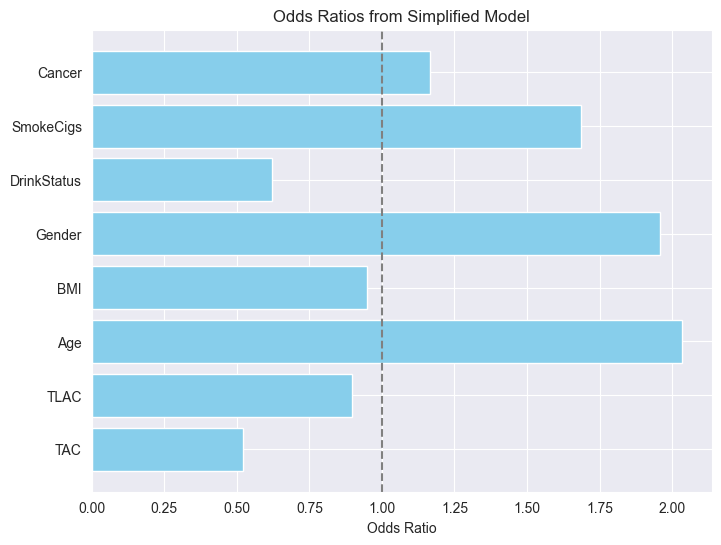

In [114]:


# Odds ratios from simplified model
odds_ratios = [0.523, 0.898, 2.034, 0.949, 1.959, 0.621, 1.686, 1.164]
features = ['TAC', 'TLAC', 'Age', 'BMI', 'Gender', 'DrinkStatus', 'SmokeCigs', 'Cancer']

plt.figure(figsize=(8, 6))
plt.barh(features, odds_ratios, color='skyblue')
plt.axvline(x=1, color='gray', linestyle='--')
plt.xlabel('Odds Ratio')
plt.title('Odds Ratios from Simplified Model')
plt.show()

In [115]:
X_interaction = X_simplified.copy()
X_interaction['Age_TAC'] = X_interaction['Age'] * X_interaction['TAC']
# Rerun the model and check the interaction term’s coefficient


Simplified Multivariate Model (Coefficients and Odds Ratios):
TAC: Coefficient = -0.649, Odds Ratio = 0.523
TLAC: Coefficient = -0.108, Odds Ratio = 0.898
Age: Coefficient = 0.710, Odds Ratio = 2.034
BMI: Coefficient = -0.053, Odds Ratio = 0.949
Gender: Coefficient = 0.672, Odds Ratio = 1.959
DrinkStatus: Coefficient = -0.477, Odds Ratio = 0.621
SmokeCigs: Coefficient = 0.522, Odds Ratio = 1.686
Cancer: Coefficient = 0.152, Odds Ratio = 1.164

Simplified Multivariate AUC: 0.800


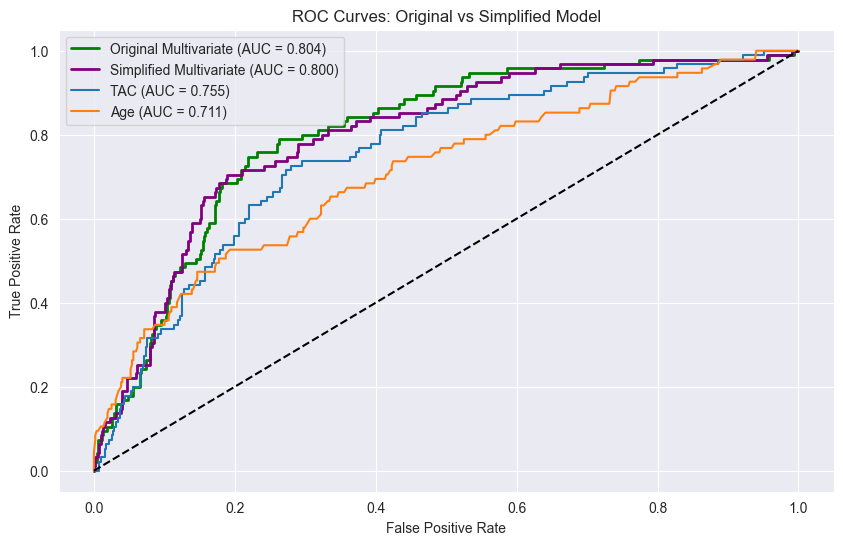

In [116]:
#### Simplified Model Code

# Simplified feature set (drop Stroke, Diabetes, CHD, CHF, DrinksPerWeek)
simplified_vars = ['TAC', 'TLAC', 'Age', 'BMI', 'Gender', 'DrinkStatus', 'SmokeCigs', 'Cancer']
X_simplified = X[simplified_vars]

# Train-test split for simplified model
X_train_simp, X_test_simp, y_train_simp, y_test_simp = train_test_split(X_simplified, y, test_size=0.2, random_state=42)

# Fit simplified multivariate model
simp_model = LogisticRegression(random_state=42, max_iter=1000)
simp_model.fit(X_train_simp, y_train_simp)
print("\nSimplified Multivariate Model (Coefficients and Odds Ratios):")
for feature, coef in zip(X_simplified.columns, simp_model.coef_[0]):
    odds_ratio = np.exp(coef)
    print(f"{feature}: Coefficient = {coef:.3f}, Odds Ratio = {odds_ratio:.3f}")

# Simplified multivariate AUC
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_prob_simp = simp_model.predict_proba(X_test_simp)[:, 1]
simp_auc = roc_auc_score(y_test_simp, y_pred_prob_simp)
print(f"\nSimplified Multivariate AUC: {simp_auc:.3f}")

# Updated ROC plot (compare original vs. simplified)
plt.figure(figsize=(10, 6))
# Original multivariate (from earlier)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_multi)  # From your earlier run
plt.plot(fpr, tpr, label=f'Original Multivariate (AUC = 0.804)', color='green', linewidth=2)
# Simplified multivariate
fpr_simp, tpr_simp, _ = roc_curve(y_test_simp, y_pred_prob_simp)
plt.plot(fpr_simp, tpr_simp, label=f'Simplified Multivariate (AUC = {simp_auc:.3f})', color='purple', linewidth=2)
# TAC and Age (for reference)
for col in ['TAC', 'Age']:
    model = LogisticRegression(random_state=42)
    model.fit(X_train[[col]], y_train)
    y_pred_prob = model.predict_proba(X_test[[col]])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{col} (AUC = {roc_auc_score(y_test, y_pred_prob):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Original vs Simplified Model')
plt.legend()
plt.show()

In [117]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

# Features and target
X = data_clean.drop('mortstat', axis=1)
y = data_clean['mortstat']

# Standardize numeric features
scaler = StandardScaler()
X[numeric_vars] = scaler.fit_transform(X[numeric_vars])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Univariate models
univariate_results = {}
for col in X.columns:
    model = LogisticRegression(random_state=42)
    model.fit(X_train[[col]], y_train)
    univariate_results[col] = model.coef_[0][0]
    print(f"{col}: Coefficient = {model.coef_[0][0]:.3f}")

# Multivariate model
multi_model = LogisticRegression(random_state=42, max_iter=1000)
multi_model.fit(X_train, y_train)
print("\nMultivariate Coefficients:")
for feature, coef in zip(X.columns, multi_model.coef_[0]):
    print(f"{feature}: {coef:.3f}")

TAC: Coefficient = -1.136
TLAC: Coefficient = -0.826
Age: Coefficient = 0.941
BMI: Coefficient = -0.108
Gender: Coefficient = 0.577
DrinkStatus: Coefficient = -0.523
DrinksPerWeek: Coefficient = -0.052
SmokeCigs: Coefficient = 0.362
Diabetes: Coefficient = 0.734
CHF: Coefficient = 1.356
CHD: Coefficient = 0.831
Cancer: Coefficient = 0.620
Stroke: Coefficient = 1.065

Multivariate Coefficients:
TAC: -0.570
TLAC: -0.089
Age: 0.729
BMI: -0.098
Gender: 0.617
DrinkStatus: -0.527
DrinksPerWeek: 0.117
SmokeCigs: 0.506
Diabetes: 0.458
CHF: 0.692
CHD: -0.026
Cancer: 0.146
Stroke: 0.234


In [118]:
# Univariate models
univariate_results = {}
for col in X.columns:
    model = LogisticRegression(random_state=42)
    model.fit(X_train[[col]], y_train)
    univariate_results[col] = model.coef_[0][0]
    print(f"{col}: Coefficient = {model.coef_[0][0]:.3f}")

# Multivariate model
multi_model = LogisticRegression(random_state=42, max_iter=1000)
multi_model.fit(X_train, y_train)
print("\nMultivariate Coefficients:")
for feature, coef in zip(X.columns, multi_model.coef_[0]):
    print(f"{feature}: {coef:.3f}")

TAC: Coefficient = -1.136
TLAC: Coefficient = -0.826
Age: Coefficient = 0.941
BMI: Coefficient = -0.108
Gender: Coefficient = 0.577
DrinkStatus: Coefficient = -0.523
DrinksPerWeek: Coefficient = -0.052
SmokeCigs: Coefficient = 0.362
Diabetes: Coefficient = 0.734
CHF: Coefficient = 1.356
CHD: Coefficient = 0.831
Cancer: Coefficient = 0.620
Stroke: Coefficient = 1.065

Multivariate Coefficients:
TAC: -0.570
TLAC: -0.089
Age: 0.729
BMI: -0.098
Gender: 0.617
DrinkStatus: -0.527
DrinksPerWeek: 0.117
SmokeCigs: 0.506
Diabetes: 0.458
CHF: 0.692
CHD: -0.026
Cancer: 0.146
Stroke: 0.234
